# Machine Learning Engineer Nanodegree
## Deep Learning
## Capstone project: Rock-paper-scissors Classifier
### by Juan Andrés Ramírez

In this notebook is described the work done for the Udacity's Machine Learning Nanodegree capstone project

First make most of the imports:

In [1]:
from sklearn.datasets import load_files       

import numpy as np
from glob import glob
import os
from keras.applications.resnet50 import preprocess_input, ResNet50
import matplotlib.pyplot as plt
import cv2 
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.preprocessing import image
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, MaxPooling2D, Conv2D, MaxPooling2D, Flatten, BatchNormalization, LeakyReLU, add, Input
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from keras.models import Sequential, Model
from sklearn.metrics import accuracy_score, confusion_matrix
from mmtc_misc_tools import plot_confusion_matrix
from PIL import Image as pil_image

from tqdm import tqdm

Using TensorFlow backend.


#### Exploring dataset
First we will start exploring the dataset and making some preprocessing. Below we load the dataset

In [2]:

#Train folder
train_folder = 'datasets/train'
validation_folder = 'datasets/validation'
test_folder = 'datasets/test'

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    img_files = np.array(data['filenames'])
    img_targets = np_utils.to_categorical(np.array(data['target']), 3)
    return img_files, img_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset(train_folder)
valid_files, valid_targets = load_dataset(validation_folder)
test_files, test_targets = load_dataset(test_folder)

# load list of classes
class_names = [name for name in os.listdir(train_folder)]

# print statistics about the dataset
def print_dataset_stats(train_files, valid_files, test_files):
    n_total_images = len(train_files)  + len(test_files) + len(valid_files)
    print('There are %d total class categories.' % len(class_names))
    print('There are %d total images.' % n_total_images)    
    print('There are %d (%d[%%]) training images.'  % (len(train_files), len(train_files)/n_total_images*100 ))
    print('There are %d (%d[%%]) validation images.'% (len(valid_files), len(valid_files)/n_total_images*100))
    print('There are %d (%d[%%]) test images.'      % (len(test_files),  len(test_files)/n_total_images*100))
    print('Classes: ')
    for class_str in class_names:
        print(' - ' + class_str)
print_dataset_stats(train_files, valid_files, test_files)

There are 3 total class categories.
There are 3219 total images.
There are 2739 (85[%]) training images.
There are 240 (7[%]) validation images.
There are 240 (7[%]) test images.
Classes: 
 - paper
 - rock
 - scissors


Now we may see some of the training images:

Train images


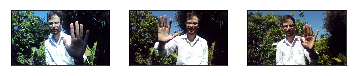

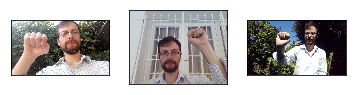

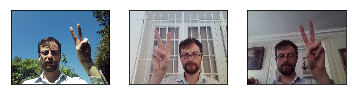

Validation images


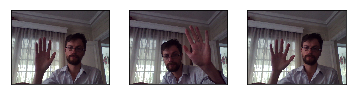

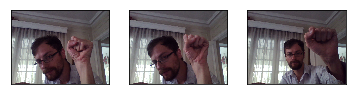

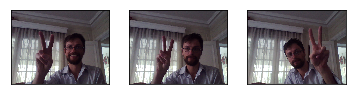

Test images


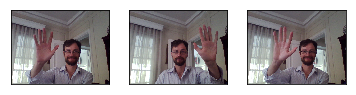

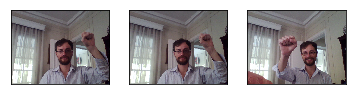

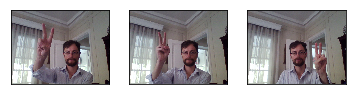

In [3]:

n_class_elements_to_show = 3

def load_image_for_show(image_path):
    img = cv2.imread(image_path)
    # convert BGR image to RGB for plotting
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return cv_rgb

def plot_img_from_path(image_path, axes=None):
    img = load_image_for_show(image_path)
    if axes:
        axes.imshow(img)
        axes.set_xticks([])
        axes.set_yticks([])
    else:
        plt.imshow(img)

def get_int_targets(targets):
    return np.array([ np.where(r==1)[0][0] for r in targets ])

def show_images_from_set(files_list, target_int):
    for class_label in range(len(class_names)):
        class_indexes = np.nonzero(target_int==class_label)    
        f, axarr = plt.subplots(1, 3)    
        for to_show in range(n_class_elements_to_show):
            img_index = class_indexes[0][to_show]
            img_path = files_list[img_index]        
            plot_img_from_path( img_path, axarr[to_show])
    plt.show()
    
train_target_int = get_int_targets(train_targets)
valid_target_int = get_int_targets(valid_targets)
test_target_int = get_int_targets(test_targets)

print("Train images")
show_images_from_set(train_files, train_target_int)
print("Validation images")
show_images_from_set(valid_files, valid_target_int)
print("Test images")
show_images_from_set(test_files, test_target_int)

### Network from scratch approach

In [4]:
def plot_training_history(history):
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

Training the model

In [5]:
#Method for train the model.
def train_model(the_model, outfilepath, show_chart=False):
    if show_chart:
        print("Shape of input: " + str(features_array_train.shape))
    checkpointer = ModelCheckpoint(filepath=outfilepath, 
                                   verbose=0, save_best_only=True)
    history = the_model.fit(features_array_train, 
                train_targets_aug, 
                #validation_split=0.2,
                validation_data=(features_array_valid, valid_targets_aug),
                epochs=400, batch_size=30, callbacks=[checkpointer], verbose=0,
                shuffle=True)
    if show_chart:
        plot_training_history(history)


Now, we check classification over some training samples

In [6]:
def classify_features(the_model, features):
    #Calc predictions
    rps_predictions = [np.argmax(the_model.predict(np.expand_dims(tensor, axis=0))) for tensor in features]
    rps_predictions_string = [class_names[class_index] for class_index in rps_predictions]
    return rps_predictions, rps_predictions_string

def classify_images(the_model, img_paths):
    paths_features = get_features_from_db(img_paths)
    return classify_features(the_model, paths_features)

#Calculate accuracy score on testing set
def calculate_testing_accuracy(test_targets_int, test_predictions):   
    testing_accuracy_score = accuracy_score(test_targets_int, test_predictions)
    return testing_accuracy_score

def make_test(the_model, the_features, the_targets, saved_weights_file, showCMatrixflag=False):
    the_model.load_weights(saved_weights_file)
    test_targets_int = get_int_targets(the_targets)
    test_predictions, test_predictions_string = classify_features(the_model, the_features)
    testing_accuracy_score = calculate_testing_accuracy(test_targets_int, test_predictions)
    testing_cm = confusion_matrix(test_targets_int, test_predictions)    
    print ('testing_accuracy_score', testing_accuracy_score)
    if showCMatrixflag:
        plt.figure()
        plot_confusion_matrix(testing_cm, classes=class_names,
                              title='Confusion matrix on test dataset')
        plt.show()
    return testing_accuracy_score

#acc_score = make_test(model_1, features_array_test, test_targets, 'saved_models/weights.best.model_db2.hdf5', True)


In [7]:
def show_prediction (img_path, pred_str):
    print('Image:', img_path, ', prediction:', pred_str)
    plot_img_from_path(img_path)
    plt.show()
    
def show_predictions(the_model, showing_paths, features):
    pred, pred_str = classify_features(the_model, features)
    for i in range(len(showing_paths)):
        show_prediction (showing_paths[i], pred_str[i])
    return pred, pred_str
def show_random_pred_samples(the_model, showing_paths, features):
    indexes = np.random.permutation(len(showing_paths))
    indexes = indexes[0:9]
    show_predictions(the_model, showing_paths[indexes], features[indexes])
    
#show_random_pred_samples(model_1, test_files, features_array_test)

Now, we train multiple times to get a better statistic of results:

In [8]:
def make_train_experiments():
    num_train = 5
    save_model_name =  'saved_models/weights.best.model_db2_stats.hdf5'
    acc_score_list=[acc_score]
    for k in range(0,num_train-1):
        a_model = create_model()
        train_model(a_model, save_model_name)
        acc = make_test(a_model, save_model_name)
        acc_score_list.append(acc)
        a_model = []
    print ("Mean acc score is %d[%%] " % (100*sum(acc_score_list)/len(acc_score_list)  ) )

### New Architecture Approach

In [9]:
from keras.preprocessing import image                  
from tqdm import tqdm
from PIL import ImageFile    

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    img_tensor = np.expand_dims(x, axis=0)
    img_preproccessed = preprocess_input(img_tensor) 
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return img_preproccessed

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)
                        
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|████████████████████████████████████████| 240/240 [00:15<00:00, 15.16it/s]


In [10]:
def create_model_na(show_summary=False):
    a_the_model = Sequential()
    a_the_model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=(224, 224, 3)))
    a_the_model.add(MaxPooling2D(pool_size=2)) # out 112
    a_the_model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu'))
    a_the_model.add(MaxPooling2D(pool_size=2))# out 56
    a_the_model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
    a_the_model.add(MaxPooling2D(pool_size=2))# out 28
    a_the_model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
    a_the_model.add(MaxPooling2D(pool_size=2))# out 28
    a_the_model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
    a_the_model.add(MaxPooling2D(pool_size=4))# out 14
    a_the_model.add(Flatten())
    a_the_model.add(Dropout(0.2))
    a_the_model.add(Dense(3, activation='softmax'))
    a_the_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    if show_summary:
        a_the_model.summary()
    return a_the_model

model_na = create_model_na(True)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 16)      1040      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 32)        2080      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 32)        4128      
__________

Shape of input: (2739, 224, 224, 3)
Epoch 1/120
Epoch 00000: val_loss improved from inf to 1.09487, saving model to saved_models/weights.best.model_scratch.hdf5
133s - loss: 1.0971 - acc: 0.3414 - val_loss: 1.0949 - val_acc: 0.3208
Epoch 2/120
Epoch 00001: val_loss improved from 1.09487 to 1.09302, saving model to saved_models/weights.best.model_scratch.hdf5
135s - loss: 1.0896 - acc: 0.3736 - val_loss: 1.0930 - val_acc: 0.3500
Epoch 3/120
Epoch 00002: val_loss did not improve
156s - loss: 1.0846 - acc: 0.3834 - val_loss: 1.0952 - val_acc: 0.3542
Epoch 4/120
Epoch 00003: val_loss did not improve
163s - loss: 1.0768 - acc: 0.4012 - val_loss: 1.1150 - val_acc: 0.3875
Epoch 5/120
Epoch 00004: val_loss did not improve
141s - loss: 1.0736 - acc: 0.4097 - val_loss: 1.1054 - val_acc: 0.3792
Epoch 6/120
Epoch 00005: val_loss did not improve
133s - loss: 1.0587 - acc: 0.4138 - val_loss: 1.1191 - val_acc: 0.4167
Epoch 7/120
Epoch 00006: val_loss did not improve
126s - loss: 1.0403 - acc: 0.4503 

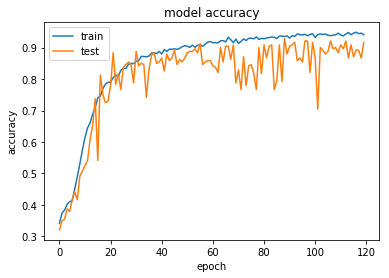

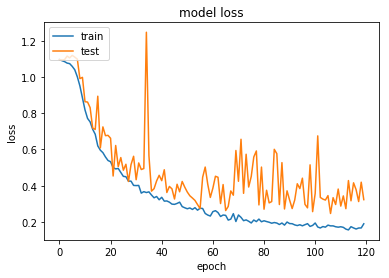

In [11]:
#Train the model.
def train_model_na(the_model, outfilepath, show_chart=False):
    if show_chart:
        print("Shape of input: " + str(train_tensors.shape))
    checkpointer = ModelCheckpoint(filepath=outfilepath, 
                                   verbose=1, save_best_only=True)    
    
    datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.1,
        height_shift_range=0.1,        
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest')

    # compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied)
    datagen.fit(train_tensors)

    # fits the model on batches with real-time data augmentation:
    history = the_model.fit_generator(datagen.flow(train_tensors, train_targets, batch_size=32),
                                      validation_data=(valid_tensors, valid_targets),
                                      steps_per_epoch=len(train_tensors) / 32,
                                      epochs=120, verbose=2, 
                                      callbacks=[checkpointer])

    #history = the_model.fit(train_tensors, train_targets, 
    #          validation_data=(valid_tensors, valid_targets),
    #          epochs=20, batch_size=128, callbacks=[checkpointer], verbose=0)
    
    if show_chart:
        plot_training_history(history)
    
train_model_na(model_na, 'saved_models/weights.best.model_scratch.hdf5', True)

testing_accuracy_score 0.9125


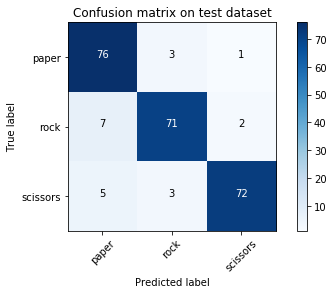

In [14]:
acc_score = make_test(model_na, test_tensors, test_targets, 'saved_models/weights.best.model_scratch.hdf5', True)

Image: datasets/test\rock\WIN_20171025_17_56_49_Pro.jpg , prediction: rock


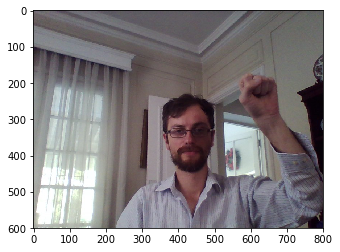

Image: datasets/test\paper\WIN_20171025_17_56_38_Pro.jpg , prediction: paper


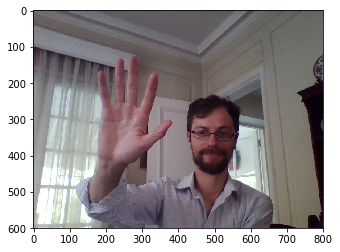

Image: datasets/test\rock\WIN_20171025_17_57_06_Pro.jpg , prediction: rock


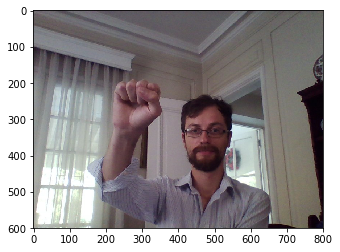

Image: datasets/test\rock\WIN_20171025_17_56_50_Pro.jpg , prediction: rock


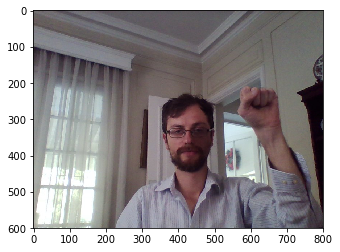

Image: datasets/test\paper\WIN_20171025_17_56_29_Pro.jpg , prediction: paper


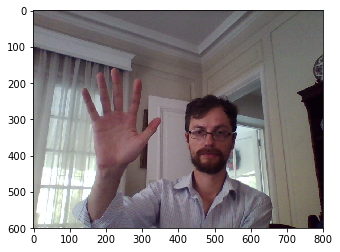

Image: datasets/test\scissors\WIN_20171025_18_00_34_Pro (2).jpg , prediction: scissors


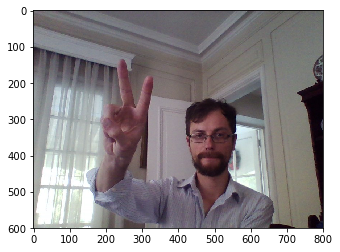

Image: datasets/test\scissors\WIN_20171025_18_00_31_Pro (2).jpg , prediction: scissors


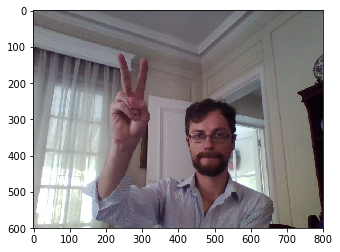

Image: datasets/test\paper\WIN_20171025_17_56_35_Pro.jpg , prediction: paper


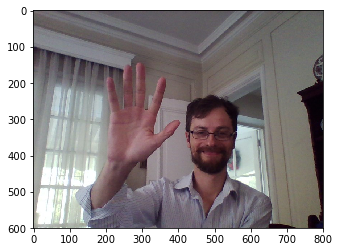

Image: datasets/test\rock\WIN_20171025_17_56_48_Pro.jpg , prediction: rock


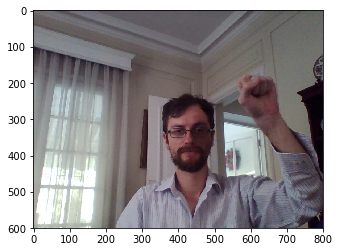

In [16]:
show_random_pred_samples(model_na, test_files, test_tensors)